# Calorimeter ML analysis

This project aims to identify electrons and pions using a sampling calorimeter. The showers of electrons and pions are modeled by a Monte Carlo simulation using the Geant4 framework.

The sampling calorimeter constructed is similar to the Hadron Calorimeter of the CMS experiment at CERN. The absorber is bronze, whereas the scintillator is plastic (vinyl toluene).

The detector geometry used is the following:
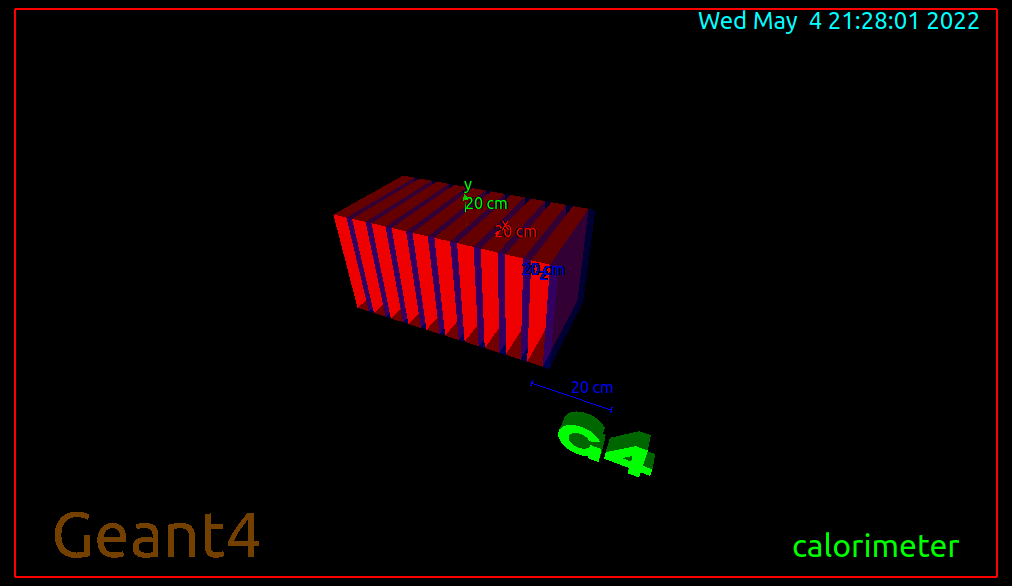

## Visually checking a few events

A particle gun is used to generate 1 GeV electrons and 1 GeV pions. The particles are parallel with the z-axis.

### Electron events:

As we can see electron showers are mostly contained in the first half of the detector.

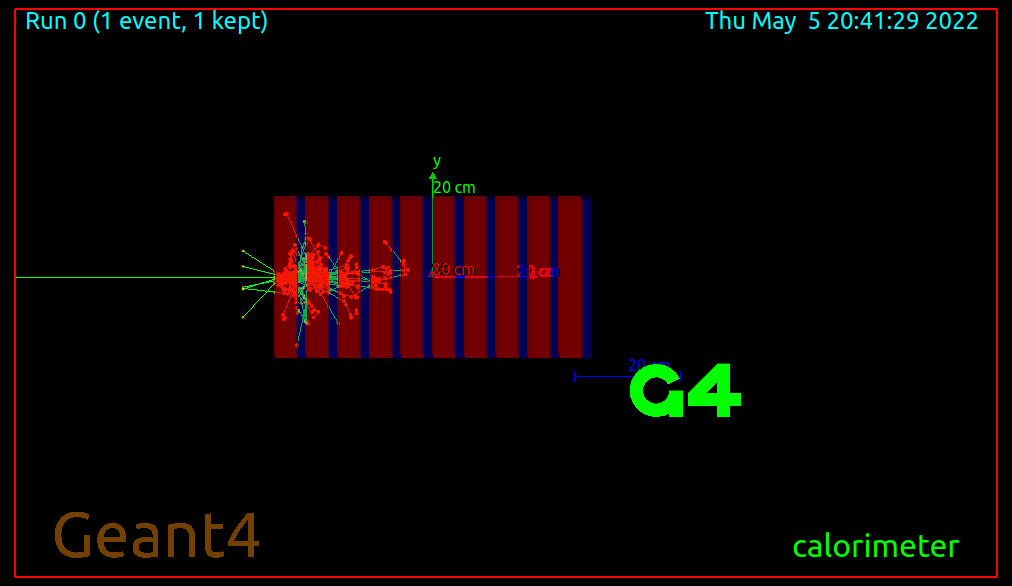

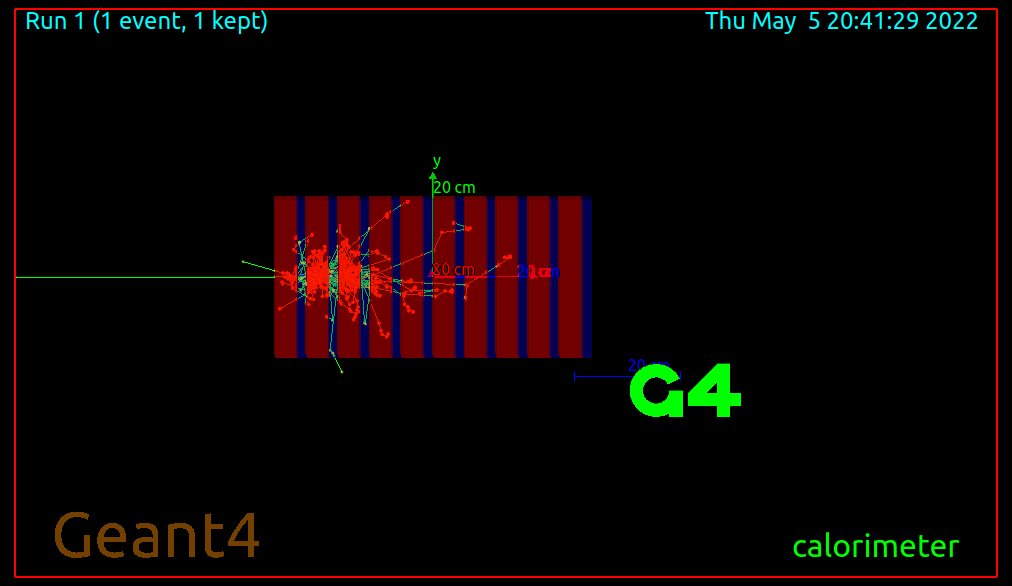

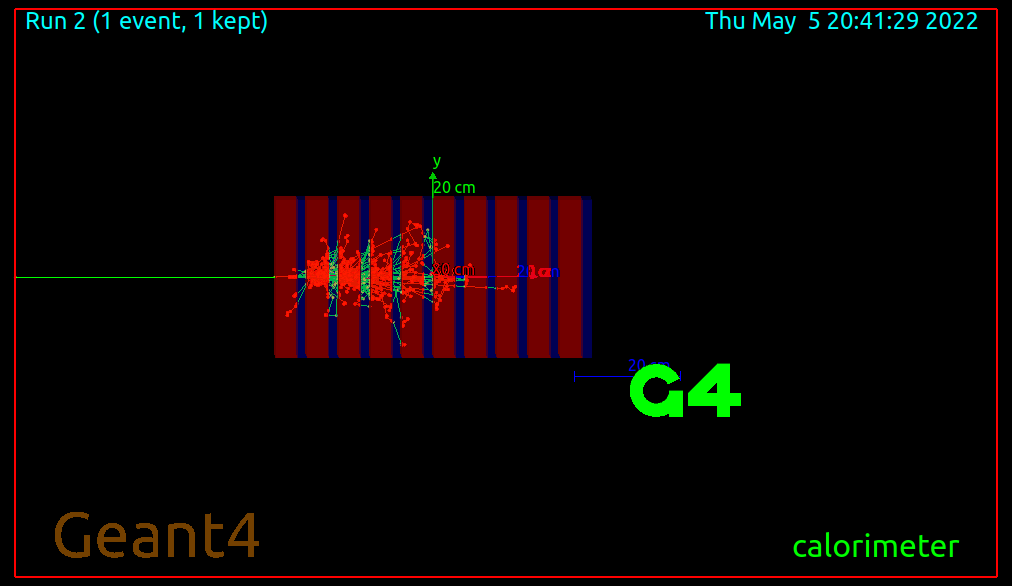

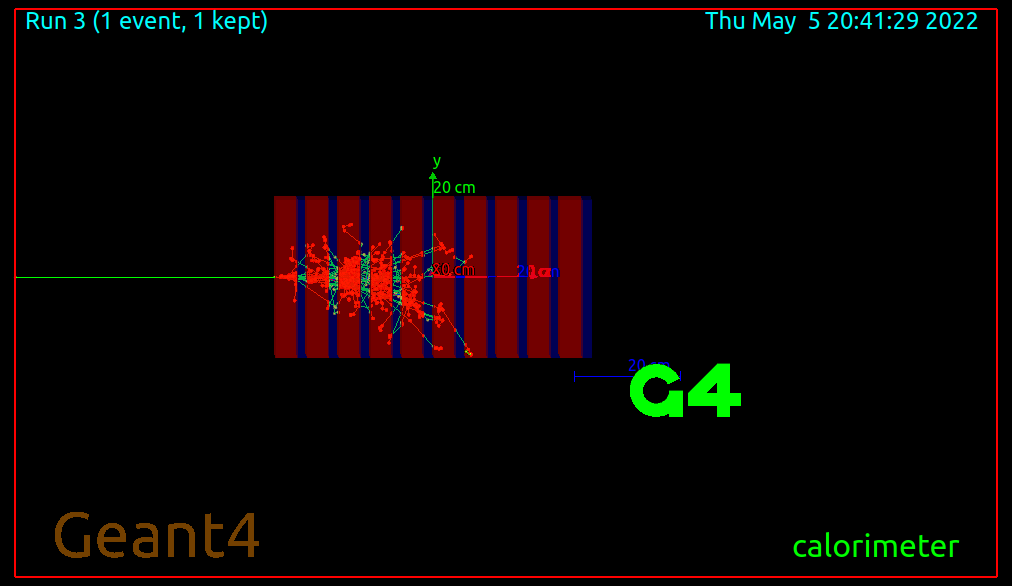

### Pion events:

Pions may penetrate much deeper into the material.

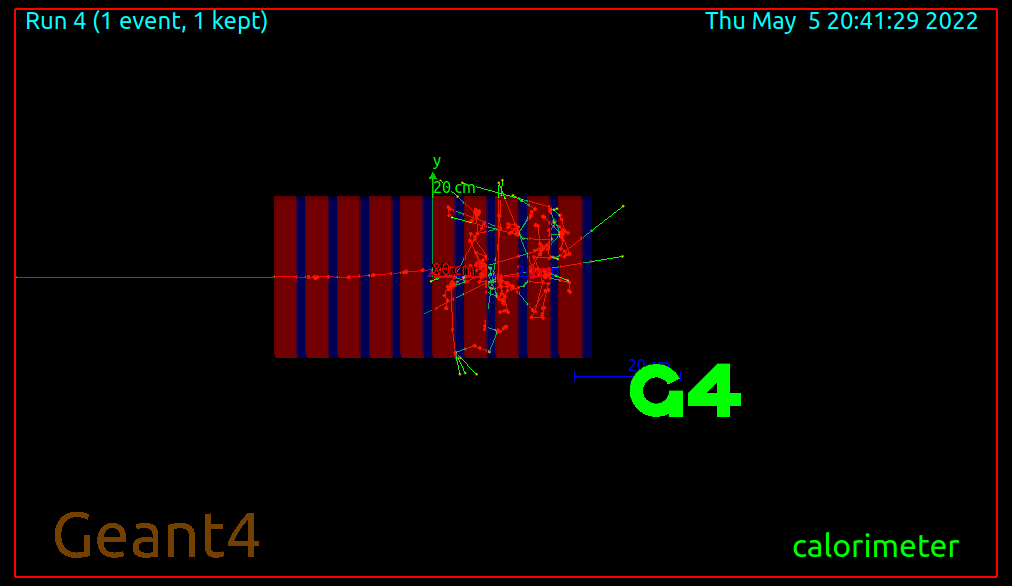

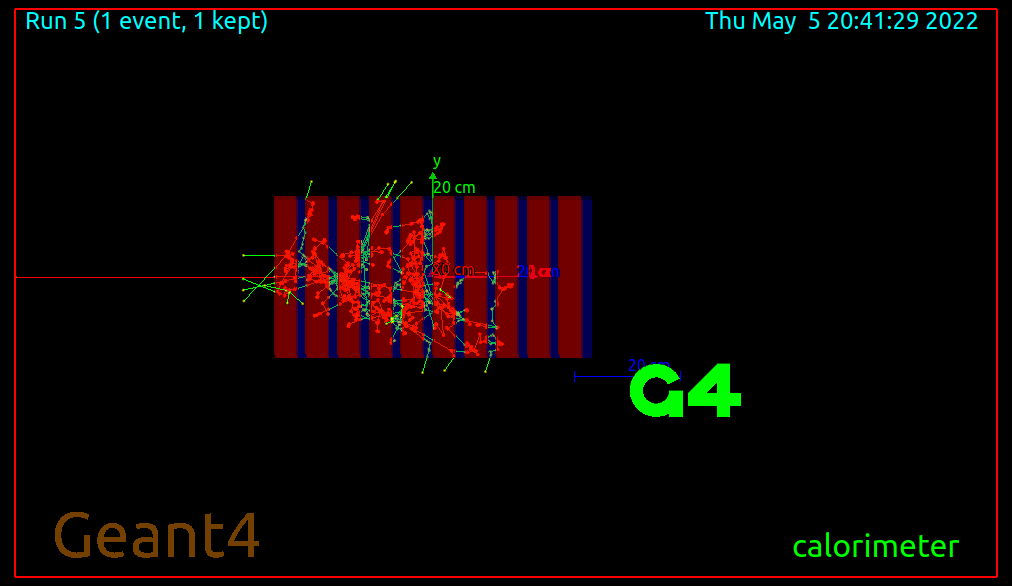

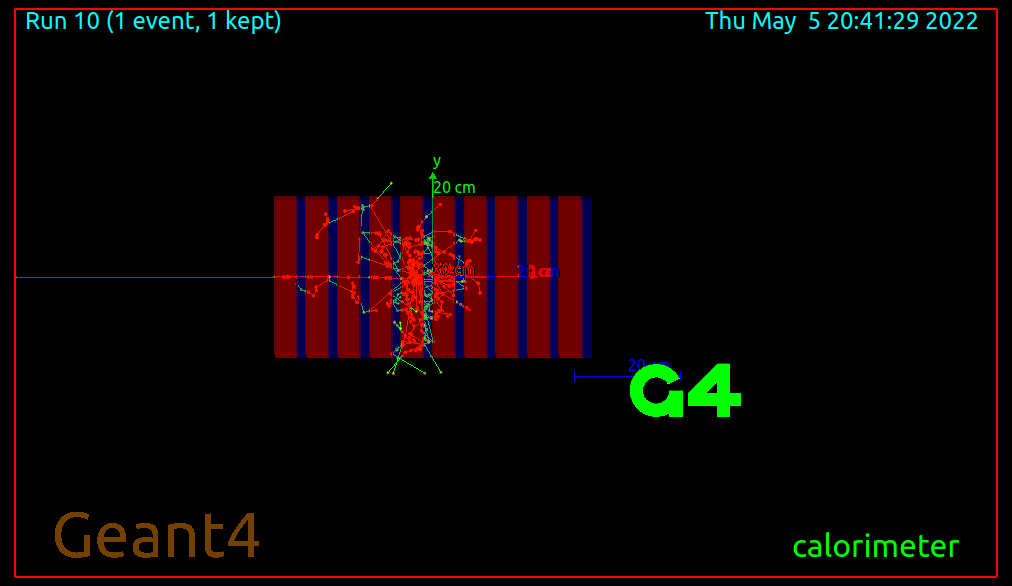

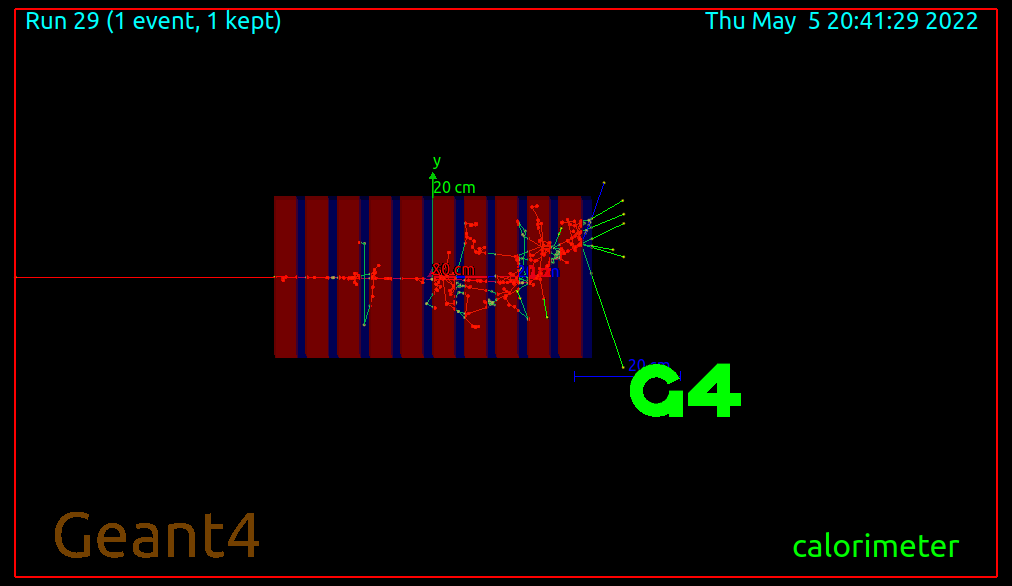

## Reading the datafiles

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_electron = pd.read_csv('electron.csv')
df_electron.head()

,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5,Layer 6,Layer 7,Layer 8,Layer 9,Layer 10
0,51.39300,5.85302,0.759443,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,18.33890,3.32175,8.141170,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,17.31210,14.40100,0.156011,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,9.91646,26.58490,6.325050,0.135384,0.114861,0.0,0.0,0.0,0.0,0.0
4,31.77530,7.30736,10.477800,1.443120,0.310088,0.0,0.0,0.0,0.0,0.0


In [4]:
df_pion = pd.read_csv('pion.csv')
df_pion.head()

,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5,Layer 6,Layer 7,Layer 8,Layer 9,Layer 10
0,7.00815,39.00580,9.848600,0.116116,0.410199,0.000000,0.0,0.0,0.0,0.0
1,21.30080,2.74168,0.303059,0.724241,0.000048,0.000000,0.0,0.0,0.0,0.0
2,3.52233,17.43110,24.726400,0.034580,0.000000,0.000000,0.0,0.0,0.0,0.0
3,4.51425,26.22520,13.266600,0.349390,0.000000,0.000000,0.0,0.0,0.0,0.0
4,13.53570,12.32800,16.229600,1.452690,3.652670,0.719565,0.0,0.0,0.0,0.0


## Checking simple quantities

### Distribution of total deposited energy

The total deposited energy is calculated by simply summing the deposited energy values for a single event. It can be seen that pions have a wider distribution, and in many cases can fully 'escape' the detector, hence the truncation at zero.

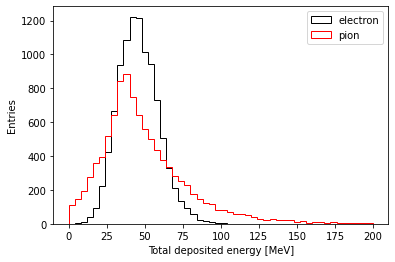

In [9]:
plt.hist(df_electron.sum(axis=1),bins=50,range=(0,200),histtype='step',edgecolor='black',label='electron')
plt.hist(df_pion.sum(axis=1),bins=50,range=(0,200),histtype='step',edgecolor='red',label='pion')
plt.xlabel("Total deposited energy [MeV]")
plt.ylabel("Entries")
plt.legend(loc="upper right")
plt.show();

### Weighted mean of channel indices

If we calculate the mean of the layer IDs, weighted by the energy deposit, then we get an approximate z-position, where the most energy was deposited: 
$$
m = \frac{\sum_i w_i \cdot i}{\sum_i w_i}
$$
From the results, it can be concluded that the electrons are mostly contained in the first two layers. On the other hand, pions can penetrate much deeper into the calorimeter material.

In [11]:
avg_z_electron = df_electron.iloc[:,0]
for i in range(1,10):
    avg_z_electron = avg_z_electron + (i+1)*df_electron.iloc[:,i]
 
avg_z_electron = avg_z_electron / df_electron.sum(axis=1)

In [12]:
avg_z_pion = df_pion.iloc[:,0]
for i in range(1,10):
    avg_z_pion = avg_z_pion + (i+1)*df_pion.iloc[:,i]
 
avg_z_pion = avg_z_pion / df_pion.sum(axis=1)

Text(0, 0.5, 'Entries')

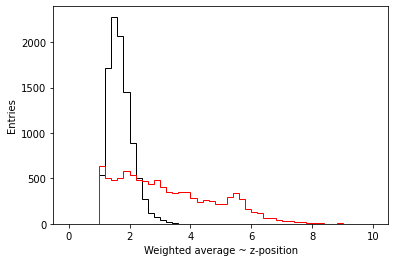

In [13]:
plt.hist(avg_z_electron,bins=50,range=(0,10),histtype='step',edgecolor='black',label='electron');
plt.hist(avg_z_pion,bins=50,range=(0,10),histtype='step',edgecolor='red',label='pion');
plt.xlabel("Weighted average ~ z-position")
plt.ylabel("Entries")

## Preparation of data for ML analyses

In [17]:
# Add particle types as a target column to dataframes
# 0 -> electron
# 1 -> pion
df_electron['Particle'] = 0
df_pion['Particle'] = 1

# Merge dataframes
df = pd.concat([df_electron,df_pion],ignore_index=True)

We do not have a priori knowledge of the incoming particle's energy. In order to take this into account, I normalize the energy deposits such that the sum of the deposits is 1 for a single event. In reality, the shower shape also depends on the energy of the particle, but in this I will neglect this.

In [18]:
# Normalizing rows
df.iloc[:,0:10] = df.iloc[:,0:10].div(df.iloc[:,0:10].sum(axis=1),axis=0)

# dropping any rows containing NaNs
df.dropna(inplace=True)

In [19]:
# extracting dataframe content into numpy arrays
X = np.array(df.iloc[:,0:10].values)
y = np.array(df['Particle'].values)

In [20]:
# Simple train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

## Logistic regression

First, using a simple linear model, logistic regression.

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.7811952988247062

In [23]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[1779,  208],
       [ 667, 1345]])

## Decision tree

Decision tree can achieve slightly better accuracy

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf2 = DecisionTreeClassifier(max_depth=2)
clf2.fit(X_train,y_train)
clf2.score(X_test,y_test)

0.8182045511377845

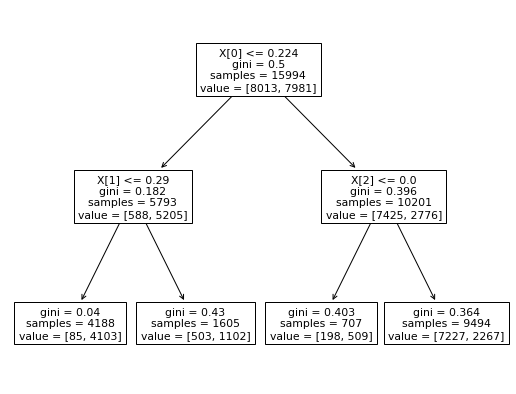

In [26]:
plt.rcParams['figure.figsize'] = [9, 7]
tree.plot_tree(clf2)
plt.show()

# The first split is based on the fraction of energy in the first layer.
# If we have less than 0.224, then it is more likely that we have a pion.
# This is in agreement with the intuitive expectation

Finally, using grid search cross validation to find optimal parameters for the decision tree. This can further improve the accuracy.

In [27]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion':('gini', 'entropy'), 'splitter':('best','random'), 'max_depth': range(1,15)}
clf3 = GridSearchCV(DecisionTreeClassifier(), parameters)
clf3.fit(X_train,y_train)
clf3.score(X_test,y_test)

0.8254563640910227

In [28]:
pd.DataFrame(clf3.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
46,0.063759,0.001208,0.000619,0.000080,entropy,10,best,"{'criterion': 'entropy', 'max_depth': 10, 'spl...",0.813379,0.834011,0.828384,0.835574,0.821451,0.826560,0.008245,1
10,0.041209,0.000770,0.000719,0.000156,gini,6,best,"{'criterion': 'gini', 'max_depth': 6, 'splitte...",0.814317,0.837762,0.825570,0.830259,0.823327,0.826247,0.007746,2
40,0.051210,0.000944,0.000586,0.000015,entropy,7,best,"{'criterion': 'entropy', 'max_depth': 7, 'spli...",0.814317,0.837449,0.826508,0.834011,0.818637,0.826184,0.008787,3
42,0.055715,0.000911,0.000576,0.000029,entropy,8,best,"{'criterion': 'entropy', 'max_depth': 8, 'spli...",0.817756,0.834011,0.824320,0.833698,0.820826,0.826122,0.006647,4
16,0.051233,0.001797,0.000563,0.000030,gini,9,best,"{'criterion': 'gini', 'max_depth': 9, 'splitte...",0.814004,0.836511,0.827446,0.830259,0.821138,0.825872,0.007722,5
14,0.048383,0.002032,0.000600,0.000041,gini,8,best,"{'criterion': 'gini', 'max_depth': 8, 'splitte...",0.816193,0.837137,0.827759,0.828384,0.819262,0.825747,0.007404,6
12,0.044365,0.001941,0.000617,0.000029,gini,7,best,"{'criterion': 'gini', 'max_depth': 7, 'splitte...",0.814630,0.838387,0.824320,0.829947,0.821138,0.825684,0.008053,7
38,0.046485,0.000695,0.000555,0.000006,entropy,6,best,"{'criterion': 'entropy', 'max_depth': 6, 'spli...",0.814942,0.837137,0.822132,0.830885,0.822702,0.825559,0.007682,8
44,0.059826,0.000653,0.000606,0.000063,entropy,9,best,"{'criterion': 'entropy', 'max_depth': 9, 'spli...",0.814630,0.833698,0.825570,0.835574,0.817386,0.825372,0.008398,9
18,0.054209,0.001743,0.000589,0.000040,gini,10,best,"{'criterion': 'gini', 'max_depth': 10, 'splitt...",0.808065,0.832760,0.828696,0.831197,0.817073,0.823558,0.009503,10


## Ensemble method: AdaBoost

Ensemble methods combine multiple weak learners to achieve to achieve a better predictive power.
Using AdaBoost with decision trees (usually called Boosted Decision Trees in the high energy physics community) can slightly improve the accuracy.

In [29]:
from sklearn.ensemble import AdaBoostClassifier

clf4 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),n_estimators=300,random_state=0)
clf4.fit(X_train,y_train)
clf4.score(X_test,y_test)

0.8422105526381596

Again, trying to find better parameters using grid search:

In [31]:
parameters = {'base_estimator':(DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)),
              'n_estimators':range(50,500,50)}
clf5 = GridSearchCV(AdaBoostClassifier(), parameters)
clf5.fit(X_train,y_train)
clf5.score(X_test,y_test)

0.8432108027006752

It can be seen that the performance cannot really improved this way.

## Simple deep learning: multilayer perceptron

Finally, checking the results of a simple neural network with two hidden layers:

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf6 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20,20), random_state=1, max_iter=1000, early_stopping=True)
clf6.fit(X_train_scaled,y_train)
clf6.score(X_test_scaled,y_test)

0.8239559889972493

The accuracy might be still improved a bit by optimizing parameters of the neural networks, but probably it would not lead to a drastic improvement, given the simple nature of the problem.